In [28]:
pip install -U spacy pydantic pydot

In [59]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
import spacy
from spacy import displacy

In [7]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [13]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

C:\Users\admin\AppData\Local\Temp\ipykernel_21108\3941007897.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


In [15]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [17]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [19]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [21]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [23]:
#Train NER Model
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [27]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()

model_bilstm_lstm(np.array(train_tokens[:1]))
plot_model(model_bilstm_lstm, show_shapes=True, show_layer_names=True)

results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
26/26 ━━━━━━━━━━━━━━━━━━━━ 736s 27s/step - accuracy: 0.8290 - loss: 1.2991 - val_accuracy: 0.9681 - val_loss: 0.2326
26/26 ━━━━━━━━━━━━━━━━━━━━ 796s 31s/step - accuracy: 0.9676 - loss: 0.2239 - val_accuracy: 0.9681 - val_loss: 0.1883
26/26 ━━━━━━━━━━━━━━━━━━━━ 747s 29s/step - accuracy: 0.9676 - loss: 0.1879 - val_accuracy: 0.9681 - val_loss: 0.1656
26/26 ━━━━━━━━━━━━━━━━━━━━ 694s 25s/step - accuracy: 0.9676 - loss: 0.1692 - val_accuracy: 0.9681 - val_loss: 0.1558
26/26 ━━━━━━━━━━━━━━━━━━━━ 596s 23s/step - accuracy: 0.9676 - loss: 0.1594 - val_accuracy: 0.9681 - val_loss: 0.1460
26/26 ━━━━━━━━━━━━━━━━━━━━ 663s 26s/step - accuracy: 0.9676 - loss: 0.1484 - val_accuracy: 0.9681 - val_loss: 0.1296
26/26 ━━━━━━━━━━━━━━━━━━━━ 563s 21s/step - accuracy: 0.9677 - loss: 0.1317 - val_accuracy: 0.9681 - val_loss: 0.1112
26/26 ━━━━━━━━━━━━━━━━━━━━ 588s 22s/step - accuracy: 0.9681 - loss: 0.1143 - val_accuracy: 0.9704 - val_loss: 

In [31]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_true, axis=-1)

    y_pred_flat = list(chain.from_iterable(y_pred))
    y_true_flat = list(chain.from_iterable(y_true))

    target_names = list(tag2idx.keys())

    print(classification_report(y_true_flat, y_pred_flat, target_names=target_names))

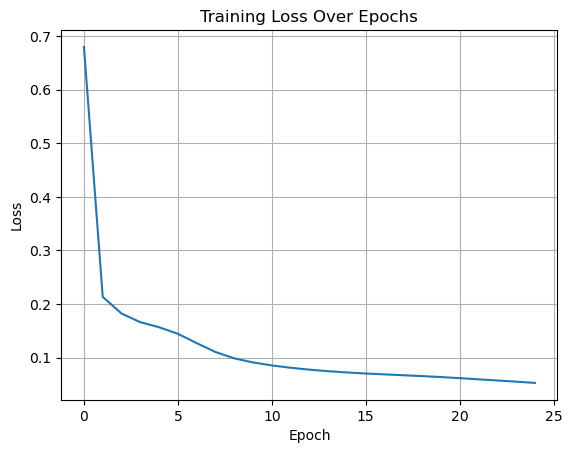

In [37]:
plt.plot(results['with_add_lstm'])
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [41]:
print("Evaluating on Test Data:")
evaluate_model(model_bilstm_lstm, test_tokens, np.array(test_tags))

Evaluating on Test Data:
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       I-per       0.76      0.79      0.78      1715
       B-art       0.00      0.00      0.00        28
       B-eve       0.00      0.00      0.00        34
       I-gpe       0.00      0.00      0.00        22
       I-art       0.00      0.00      0.00        28
       B-per       0.63      0.52      0.57      1697
       B-nat       0.00      0.00      0.00        17
       B-org       0.53      0.29      0.38      2038
       B-tim       0.68      0.60      0.64      1994
       I-tim       0.00      0.00      0.00       674
           O       1.00      1.00      1.00    482811
       B-geo       0.59      0.90      0.71      3690
       I-nat       0.00      0.00      0.00         7
       I-geo       0.61      0.39      0.48       681
       I-eve       0.00      0.00      0.00        23
       B-gpe       0.95      0.12      0.21      1628
       I-org       0.49      0.61      0.55      1697

    accuracy              

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
model_bilstm_lstm.save("ner_bilstm_lstm_model.h5")

In [65]:
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Mohamed Adhil \n I am from India \n I want to work with Microsoft')
displacy.render(text, style = 'ent', jupyter=True)